![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/2.Clinical_Assertion_Model.ipynb)

# Clinical Assertion Model

## Colab Setup

In [ ]:
import json

with open('license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

secret = license_keys['secret']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['JSL_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']

! python -m pip install --upgrade spark-nlp-jsl==2.4.2  --extra-index-url https://pypi.johnsnowlabs.com/$secret

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl


def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "8G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "900M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-2.4.2.jar")
      
    return builder.getOrCreate()


spark = start(secret) # if you want to start the session with custom params as in start function above
# sparknlp_jsl.start(secret)

In [ ]:
spark

# Clinical Assertion Model (with pretrained models)

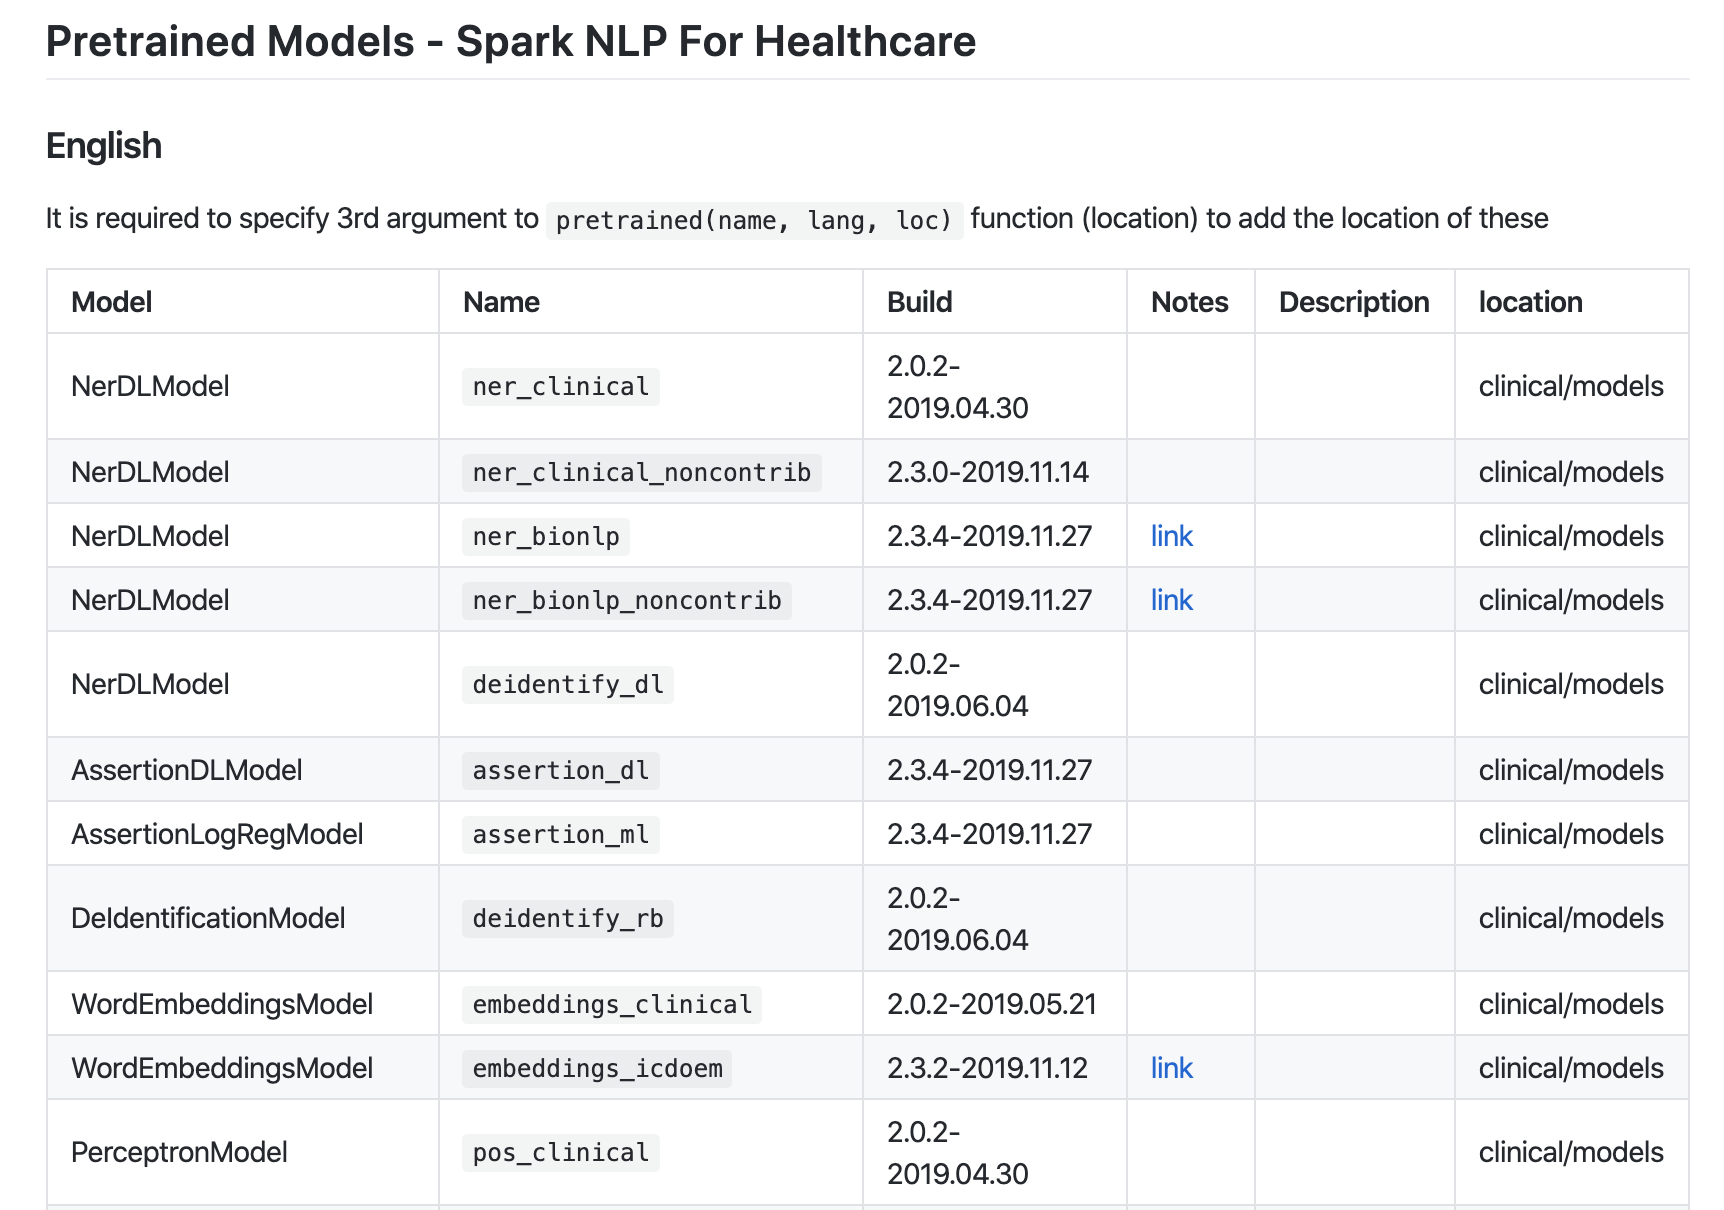

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

# Assertion model trained on i2b2 (sampled from MIMIC) dataset
# coming from sparknlp_jsl.annotator !!
clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    clinical_assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]


In [ ]:
! wget 	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv


--2020-04-09 19:07:27--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.225.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.225.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9363435 (8.9M) [text/csv]
Saving to: ‘pubmed_sample_text_small.csv’

pubmed_sample_text_ 100%[===================>]   8.93M  --.-KB/s    in 0.1s    

2020-04-09 19:07:27 (65.5 MB/s) - ‘pubmed_sample_text_small.csv’ saved [9363435/9363435]



In [ ]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"""Monomeric sarcosine oxidase (MSOX) is a flav...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
result = model.transform(pubMedDF.limit(100))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|           assertion|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 17, 19, ...|[[assertion, 17, ...|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 67, 79, ...|[[assertion, 67, ...|
|OBJECTIVE: To inv...|[[document, 0, 15...|[[document, 0, 30...|[[token, 0, 8, OB...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 130, 152...|[[

In [ ]:
result.select('text').take(3)

[Row(text='The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activated inwardly rectifying potassium (GIRK) channel family. Here we describe the genomicorganization of the KCNJ9 locus on chromosome 1q21-23 as a candidate gene forType II diabetes mellitus in the Pima Indian population. The gene spansapproximately 7.6 kb and contains one noncoding and two coding exons separated byapproximately 2.2 and approximately 2.6 kb introns, respectively. We identified14 single nucleotide polymorphisms (SNPs), including one that predicts aVal366Ala substitution, and an 8 base-pair (bp) insertion/deletion. Ourexpression studies revealed the presence of the transcript in various humantissues including pancreas, and two major insulin-responsive tissues: fat andskeletal muscle. The characterization of the KCNJ9 gene should facilitate furtherstudies on the function of the KCNJ9 protein and allow evaluation of thepotential role of the locus in Type II diabetes.'),
 Row(text='BACKGROUND: At pr

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result',  'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata', 'assertion.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"),
        F.expr("cols['3']['sentence']").alias("sent_id"),
        F.expr("cols['4']").alias("assertion"),).show(truncate=False)


+---------------------------------------------+-----+---+---------+-------+---------+
|chunk                                        |begin|end|ner_label|sent_id|assertion|
+---------------------------------------------+-----+---+---------+-------+---------+
|Kir                                          |17   |19 |TEST     |0      |present  |
|GIRK3                                        |26   |30 |TEST     |0      |present  |
|chromosome 1q21-23                           |188  |205|TREATMENT|1      |present  |
|a candidate gene forType II diabetes mellitus|210  |254|PROBLEM  |1      |possible |
|coding exons                                 |357  |368|TEST     |2      |absent   |
|byapproximately                              |380  |394|TEST     |2      |present  |
|introns                                      |425  |431|TEST     |2      |absent   |
|single nucleotide polymorphisms (SNPs        |464  |500|PROBLEM  |3      |present  |
|aVal366Ala substitution                      |532  |5

In [ ]:
import pandas as pd

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge .
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonat

,chunks,entities,assertion
0,gestational diabetes mellitus,PROBLEM,present
1,type two diabetes mellitus,PROBLEM,present
2,"T2DM ),",PROBLEM,present
3,HTG-induced pancreatitis,PROBLEM,present
4,an acute hepatitis,PROBLEM,present
...,...,...,...
66,SGLT2 inhibitor,TREATMENT,present
67,insulin glargine,TREATMENT,present
68,insulin lispro,TREATMENT,present
69,metformin,TREATMENT,present


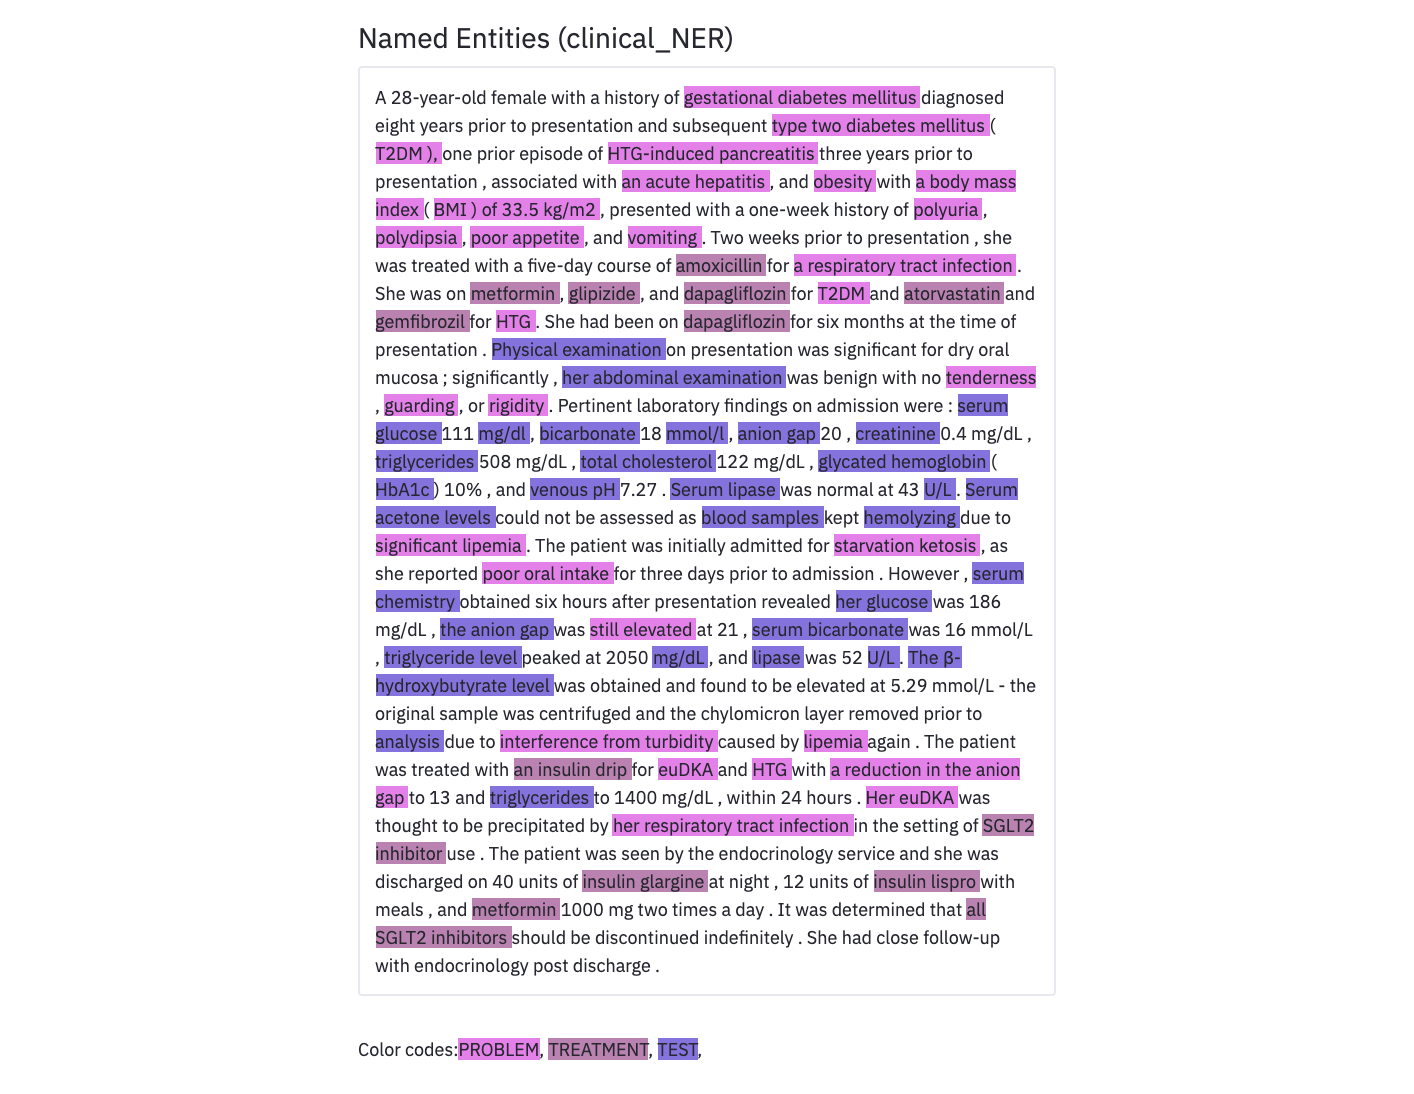

## Writing a generic Assertion + NER function

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id


def get_base_pipeline (embeddings = 'embeddings_clinical'):

  documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line

  sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP

  tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  return model



def get_clinical_assertion (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
  loaded_ner_model = NerDLModel.pretrained(model_name, "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

  ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

  # Assertion model trained on i2b2 (sampled from MIMIC) dataset
  # coming from sparknlp_jsl.annotator !!
  clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
      .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
      .setOutputCol("assertion")
      

  base_model = get_base_pipeline (embeddings)

  nlpPipeline = Pipeline(stages=[
      base_model,
      loaded_ner_model,
      ner_converter])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  result = model.transform(spark_df.limit(nrows))

  result = result.withColumn("id", monotonically_increasing_id())

  result_df = result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata', 'assertion.result')).alias("cols")) \
  .select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label"),
        F.expr("cols['2']").alias("assertion"))\
        .filter("ner_label!='O'")

  return result_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+--------------------+---------+---------+
|               chunk|ner_label|assertion|
+--------------------+---------+---------+
|                 Kir|     TEST|  present|
|               GIRK3|     TEST|  present|
|  chromosome 1q21-23|TREATMENT|  present|
|a candidate gene ...|  PROBLEM| possible|
|        coding exons|     TEST|   absent|
|     byapproximately|     TEST|  present|
|             introns|     TEST|   absent|
|single nucleotide...|  PROBLEM|  present|
|aVal366Ala substi...|TREATMENT|  present|
|      an 8 base-pair|  PROBLEM|  present|
|                 bp)|     TEST|  present|
|Ourexpression stu...|     TEST|  present|
|The characterizat...|     TEST|  present|
|      furthe

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------+---------+---------+
|           chunk|ner_label|assertion|
+----------------+---------+---------+
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG| possible|
|  Vinorelbinewas|     DRUG|  present|
|       25 mg/m(2| STRENGTH|  present|
|   intravenously|    ROUTE|  present|
|         on days|FREQUENCY|  present|
|tumorprogression|     DRUG|  present|
| thatvinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|   absent|
| tetrazolium dye|     DRUG|  present|

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

entry_data = spark.createDataFrame([["The patient didn't take a capsule of Advil"]]).toDF("text")

ner_df = get_clinical_assertion (embeddings, entry_data, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+-------+---------+---------+
|  chunk|ner_label|assertion|
+-------+---------+---------+
|capsule|     FORM|  present|
|  Advil|     DRUG|     null|
+-------+---------+---------+



In [ ]:
import pandas as pd

def get_clinical_assertion_light (light_model, text):

  light_result = light_model.fullAnnotate(text)[0]

  chunks=[]
  entities=[]
  status=[]

  for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
      
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      status.append(m.result)
          
  df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

  return df

In [ ]:
clinical_text = """
Patient with severe fever and sore throat. 
He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs.
After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""

light_model = LightPipeline(model)

get_clinical_assertion_light (light_model, clinical_text)


,chunks,entities,assertion
0,severe fever,PROBLEM,present
1,sore throat,PROBLEM,present
2,stomach pain,PROBLEM,absent
3,an epidural,TREATMENT,present
4,PCA,TREATMENT,present
5,pain control,PROBLEM,present
6,short of breath,PROBLEM,conditional
7,CT,TEST,present
8,lung tumor,PROBLEM,present
9,Alzheimer,PROBLEM,associated_with_someone_else


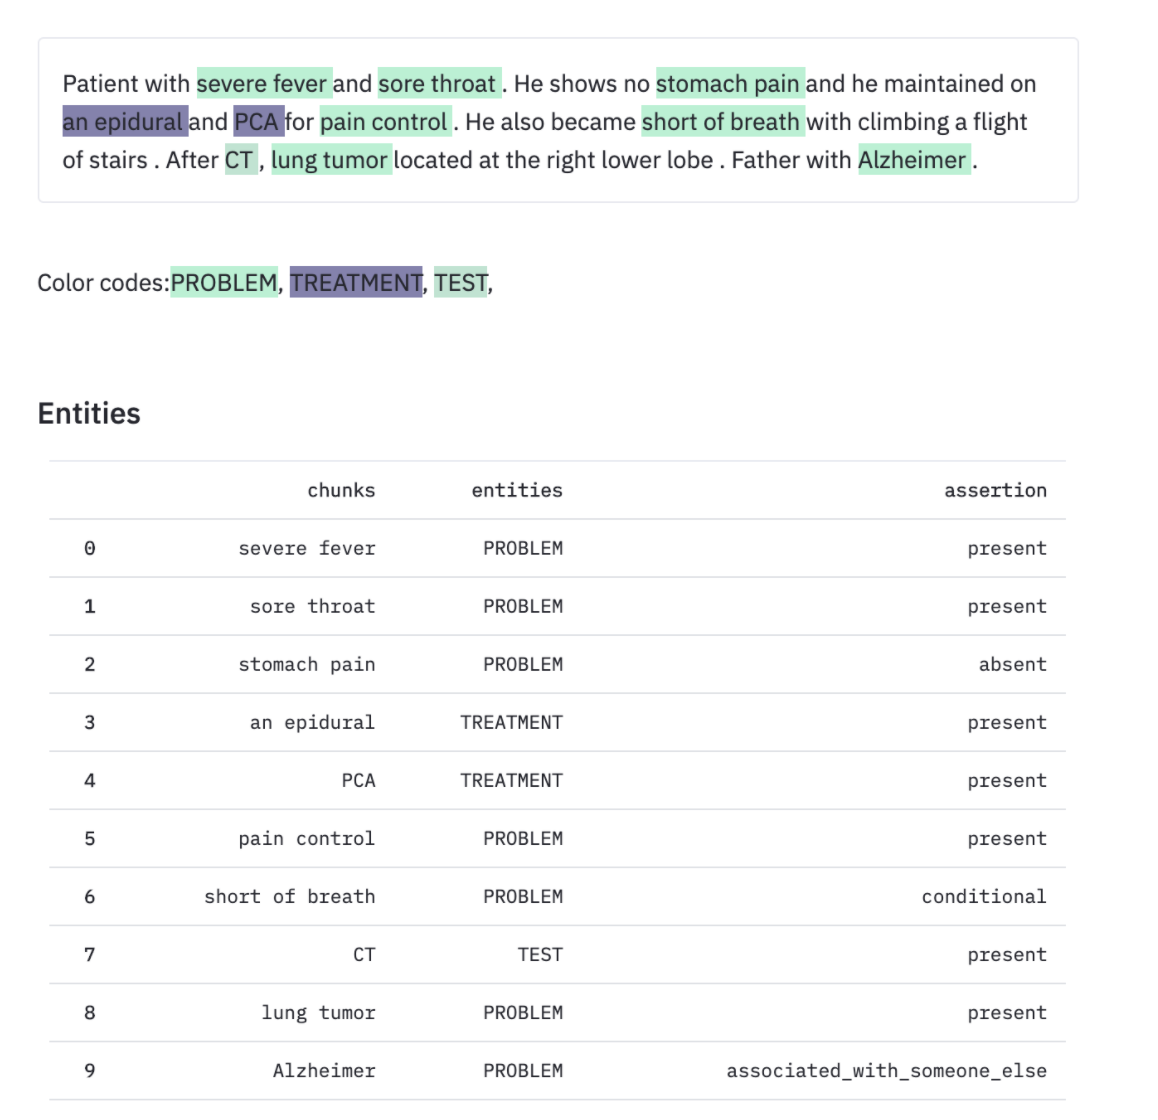

## Assertion with BioNLP (Cancer Genetics) NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show(truncate = False)

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------------+--------------------+---------+
|chunk                 |ner_label           |assertion|
+----------------------+--------------------+---------+
|human                 |Organism            |present  |
|Kir 3.3               |Gene_or_gene_product|present  |
|GIRK3                 |Gene_or_gene_product|present  |
|potassium             |Simple_chemical     |possible |
|GIRK                  |Gene_or_gene_product|absent   |
|chromosome 1q21-23    |Cellular_component  |present  |
|pancreas              |Organ               |absent   |
|tissues               |Tissue              |present  |
|fat andskeletal muscle|Tissue              |present  |
|KCNJ9                 |Gene_or

# Train your Assertion Model

In [ ]:
!wget https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv

--2020-04-09 18:20:58--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992836 (970K) [text/csv]
Saving to: ‘i2b2_assertion.csv’

i2b2_assertion.csv  100%[===================>] 969.57K  --.-KB/s    in 0.09s   

2020-04-09 18:20:58 (11.1 MB/s) - ‘i2b2_assertion.csv’ saved [992836/992836]



In [ ]:
import pandas as pd

In [ ]:

assertion_df = spark.read.option("header", True).option("inferSchema", "True").csv("i2b2_assertion.csv")


In [ ]:
assertion_df.show(3, truncate=100)

+----------------------------------------------------------------------------------------------------+------------------------+-------+-----+---+
|                                                                                                text|                  target|  label|start|end|
+----------------------------------------------------------------------------------------------------+------------------------+-------+-----+---+
|     Abnormal Pap Test , history of ; Bacterial Vaginitis ; Contraception Management ; Hiv Counseled|       abnormal pap test|present|    0|  2|
|MOUTH NORMAL NECK NORMAL thyroid wnl BREASTS NORMAL no distinct masses NIPPLES NORMAL inverted [ ...|white d / c at introitus|present|   42| 47|
|MOUTH NORMAL NECK NORMAL thyroid wnl BREASTS NORMAL no distinct masses NIPPLES NORMAL inverted [ ...|         distinct masses| absent|    9| 10|
+----------------------------------------------------------------------------------------------------+----------------------

In [ ]:

document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

chunk = Doc2Chunk()\
    .setInputCols("document")\
    .setOutputCol("chunk")\
    .setChunkCol("target")\
    .setStartCol("start")\
    .setStartColByTokenIndex(True)\
    .setFailOnMissing(False)\
    .setLowerCase(True)

token = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["document", "token"])\
      .setOutputCol("embeddings")


In [ ]:

assertionStatus = AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setDropout(0.012)\
    .setLearningRate(0.015)\
    .setEpochs(6)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setMaxSentLen(250)

clinical_assertion_pipeline = Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertionStatus])



In [ ]:
%%time

assertion_model = clinical_assertion_pipeline.fit(training_data)